In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, load_from_disk
from transformers import BertTokenizer, BertForSequenceClassification, AdamW 
from torcheval.metrics import BinaryAccuracy
import argparse
import os

from preprocess import Preprocessor
from utils import training_epoch, validation_epoch, plot_losses

from transformers import logging

logging.set_verbosity_error()
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


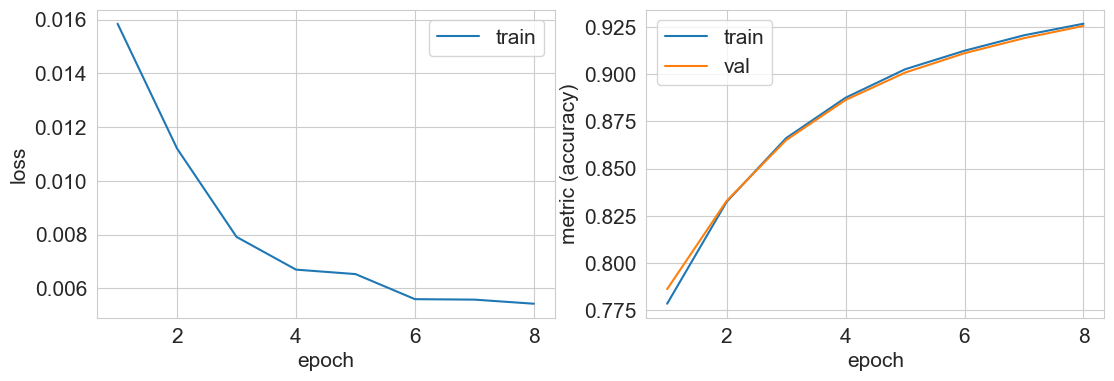

In [4]:
# Загрузка данных и разделение на тренировочную и валидационную выборки
parser = argparse.ArgumentParser(description='Please enter model name to save')

dataset_path = "../data/rotten_tomatoes"

# Проверяем, существует ли локальный файл
if os.path.exists(dataset_path):
    # Если файл существует, загружаем датасет из локального файла
    loaded_dataset = load_from_disk(dataset_path)
    print("Dataset loaded from local disk.")
else:
    # Если файл не существует, загружаем датасет из интернета и сохраняем его
    dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")
    dataset.save_to_disk(dataset_path)
    loaded_dataset = dataset
    print("Dataset downloaded and saved to local disk.")

train_data = loaded_dataset['train']
val_data = loaded_dataset['validation']
# Токенизация
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
preprocessor = Preprocessor(tokenizer, max_length=32)
train_data = train_data.map(preprocessor, batched=True)
val_data = val_data.map(preprocessor, batched=True)

# Создание DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Создание модели
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Обучение модели
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, no_deprecation_warning=True)
criterion = torch.nn.BCELoss()
metric = BinaryAccuracy()
is_cuda = next(model.parameters()).is_cuda
print("model is on cuda" if is_cuda else "model is not in cuda")
num_epochs = 8
train_losses, train_metrics, val_metrics = [], [], []
for epoch in range(1, num_epochs + 1):
    train_loss, train_metric = training_epoch(
        model, optimizer, criterion, train_loader,
        tqdm_desc=f'Training {epoch}/{num_epochs}',
        metric = metric
    )
    val_metric = validation_epoch(
        model, criterion, val_loader,
        tqdm_desc=f'Validating {epoch}/{num_epochs}',
        metric=metric
    )
    train_losses += [train_loss]
    train_metrics += [train_metric.tolist()]
    val_metrics += [val_metric.tolist()]

plot_losses(train_losses, train_metrics, val_metrics) 

In [6]:
dataset_path = "../data/rotten_tomatoes"

# Проверяем, существует ли локальный файл
if os.path.exists(dataset_path):
    # Если файл существует, загружаем датасет из локального файла
    loaded_dataset = load_from_disk(dataset_path)
    print("Dataset loaded from local disk.")
else:
    # Если файл не существует, загружаем датасет из интернета и сохраняем его
    dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")
    dataset.save_to_disk(dataset_path)
    loaded_dataset = dataset
    print("Dataset downloaded and saved to local disk.")

test_data = loaded_dataset['test']
# Токенизация

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
preprocessor = Preprocessor(tokenizer, max_length=64)
test_data = test_data.map(preprocessor, batched=True)

path = "../models/bert-mixup-finetuned"

model = BertForSequenceClassification.from_pretrained(path)


input_ids_test = torch.tensor(test_data['input_ids'])
attention_mask_test = torch.tensor(test_data['attention_mask'])
labels_test = torch.tensor(test_data['label'])

outputs = model(input_ids=input_ids_test, attention_mask=attention_mask_test, labels=labels_test)

preds = torch.argmax(outputs.logits.detach(), dim=1)
accuracy = accuracy_score(labels_test, preds)
precision = precision_score(labels_test, preds)
recall = recall_score(labels_test, preds)
f1 = f1_score(labels_test, preds)
print(f"\tAccuracy: {accuracy}")
print(f"\tPrecision: {precision}")
print(f"\tRecall: {recall}")
print(f"\tf1 score: {f1}")

Dataset loaded from local disk.


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

	Accuracy: 0.8470919324577861
	Precision: 0.8571428571428571
	Recall: 0.8330206378986866
	f1 score: 0.8449096098953376
